In [1]:
%matplotlib inline
%autosave 0
%load_ext autoreload
%autoreload 2

Autosave disabled


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from dtrace import rpath
from dtrace.TargetHit import TargetHit
from dtrace.DTracePlot import DTracePlot
from dtrace.Associations import Association

### Import data-sets and associations

In [3]:
assoc = Association(dtype="ic50", load_associations=True)
lmm_combined = pd.concat(
    [
        assoc.lmm_drug_crispr.set_index(
            ["DRUG_ID", "DRUG_NAME", "VERSION", "GeneSymbol"]
        ).add_prefix("CRISPR_"),
        assoc.lmm_drug_gexp.set_index(
            ["DRUG_ID", "DRUG_NAME", "VERSION", "GeneSymbol"]
        ).add_prefix("GExp_"),
    ],
    axis=1,
    sort=False,
).dropna()

/Users/eg14/anaconda3/envs/crispy/lib/python3.6/site-packages/ipykernel_launcher.py:1: DtypeWarning: Columns (6,28) have mixed types. Specify dtype option on import or set low_memory=False.
  """Entry point for launching an IPython kernel.


[2019-02-26 18:36:24,113 - INFO]: #(Samples)=500
[2019-02-26 18:36:26,535 - INFO]: #(Drugs)=589; #(Genes)=16818; #(Genomic)=536; 


## MCL1 inhibitors associations

Analysis of the significant associations between multiple MCL1 inhibitors (MCL1i) and MCL1 and MARCH5
gene-essentiality.

In [5]:
hit = TargetHit(
    "MCL1",
    lmm_dcrispr=assoc.lmm_drug_crispr,
    lmm_dgexp=assoc.lmm_drug_gexp,
    lmm_comb=lmm_combined,
)

### Top associations with MCL1i

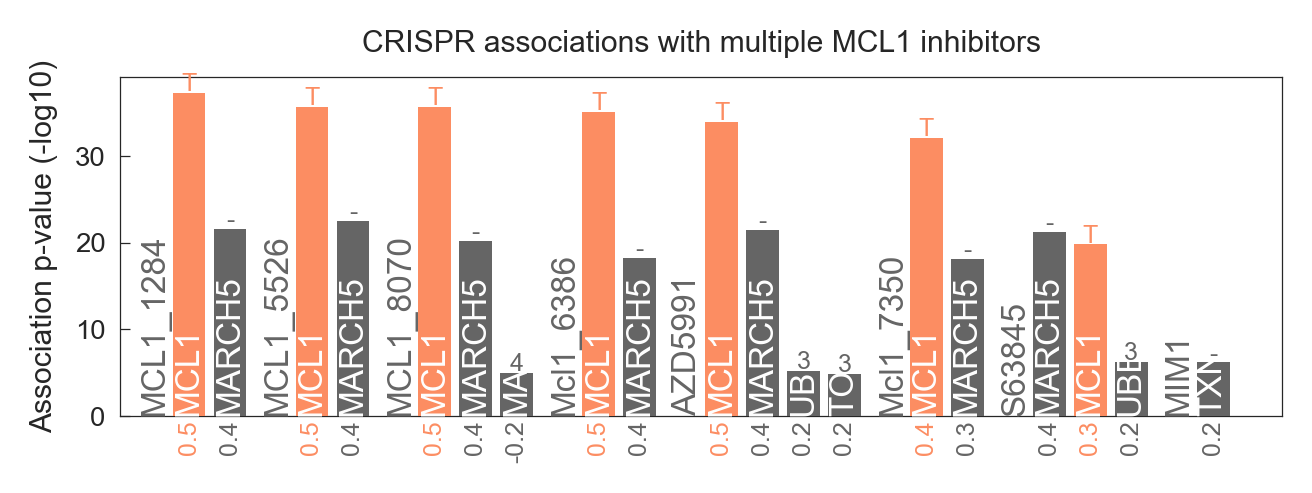

In [6]:
hit.top_associations_barplot()
plt.ylabel("Association p-value (-log10)")
plt.title("CRISPR associations with multiple MCL1 inhibitors")
plt.gcf().set_size_inches(5, 1.5)
plt.savefig(f"{rpath}/hit_topbarplot.pdf", bbox_inches="tight", transparent=True)

### Correlation plots of multiple MCL1i and MCL1/MARCH5

/Users/eg14/anaconda3/envs/crispy/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


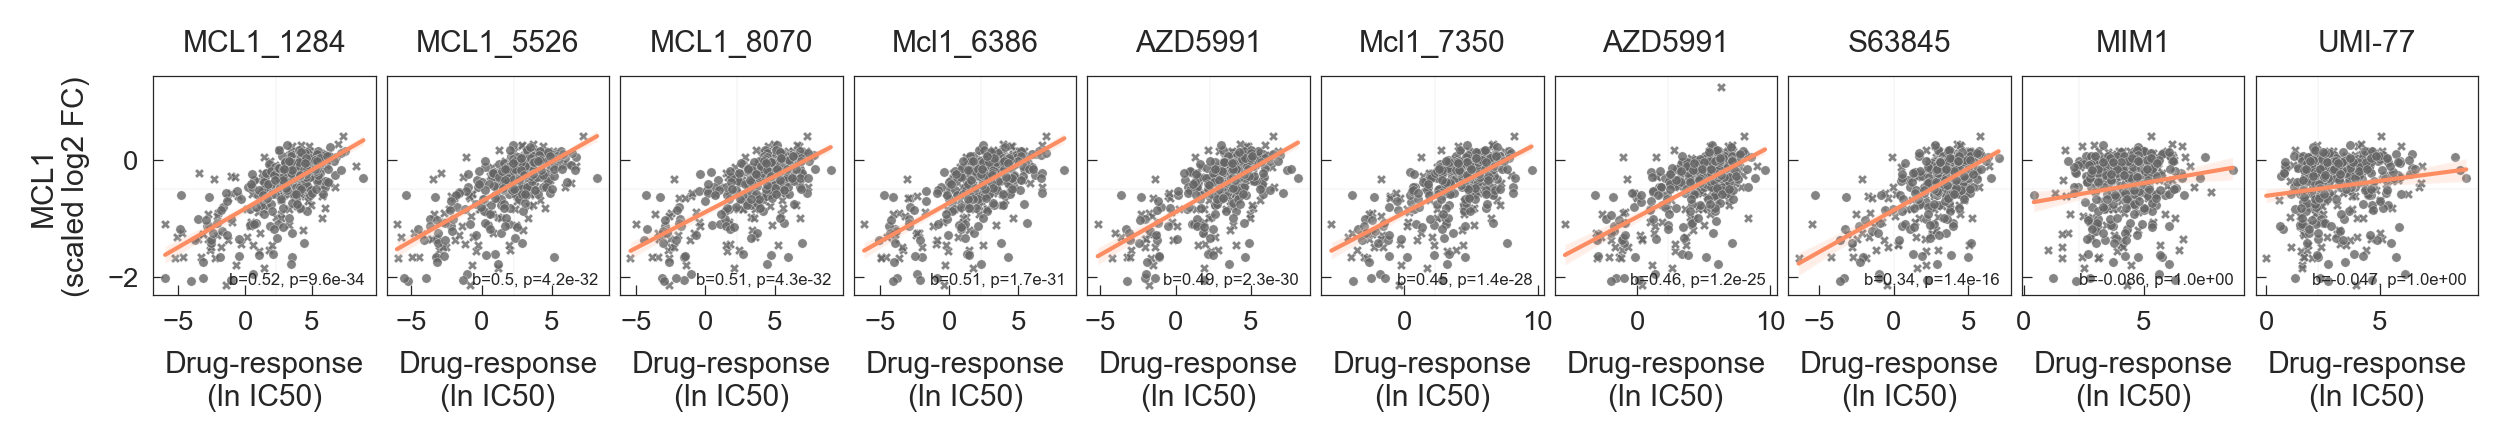

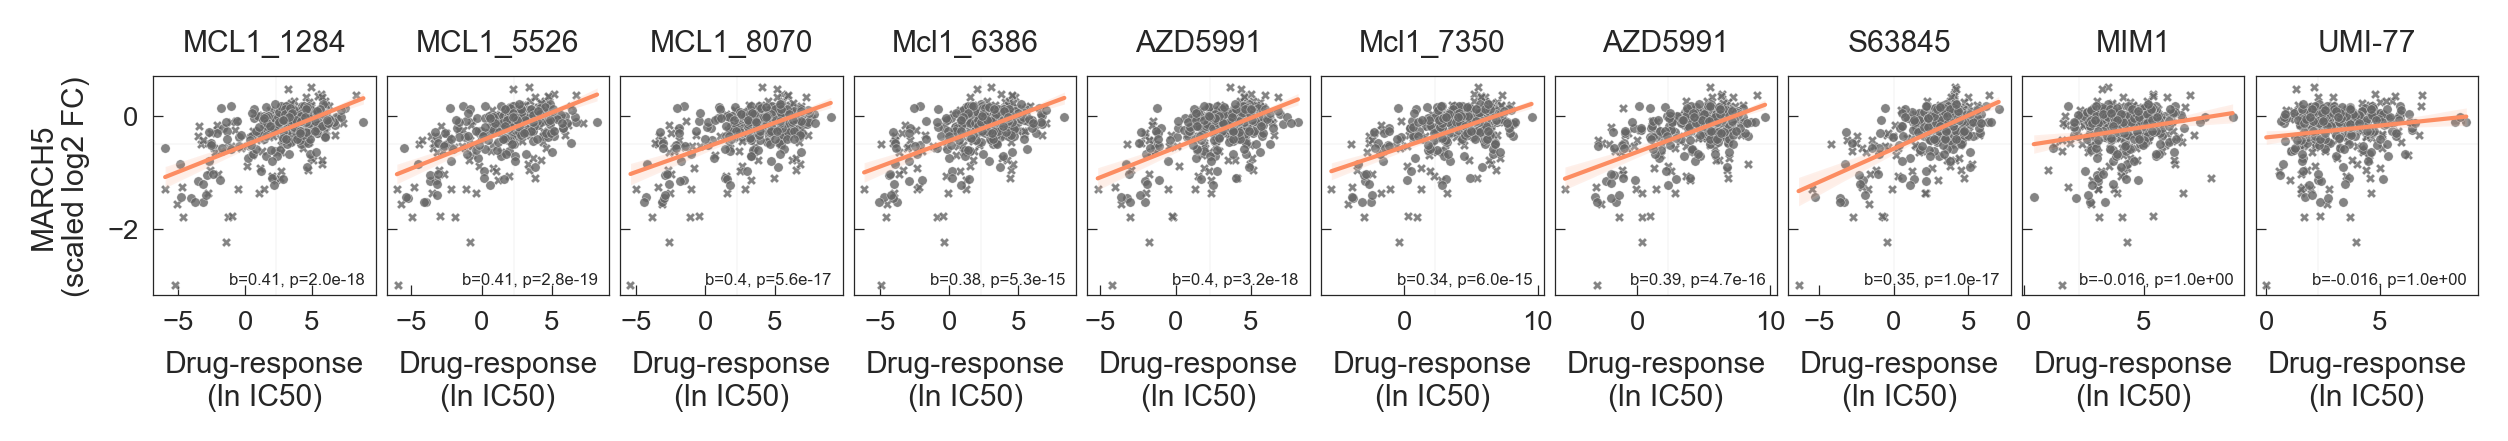

In [7]:
order = [
    tuple(d)
    for d in assoc.lmm_drug_crispr.query(
        f"(DRUG_TARGETS == 'MCL1') & (GeneSymbol == 'MCL1')"
    )[hit.dinfo].values
]
for g in ["MCL1", "MARCH5"]:
    hit.plot_target_drugs_corr(assoc, g, order=order)

    plt.savefig(
        f"{rpath}/hit_target_drugs_corr_{g}.pdf", bbox_inches="tight", transparent=True
    )

### BCL inhbitors association effects

Associations effect sizes (betas) of inhibitors of BCL family members (MCL1, BCL2L1/BCL-XL and BCL2) drug-response
with gene-essentiality and gene-expression.

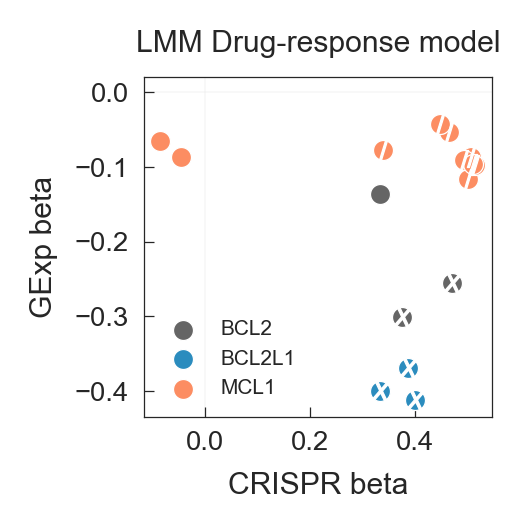

In [8]:
plt.figure(figsize=(1.5, 1.5), dpi=300)
hit.plot_drug_crispr_gexp(["MCL1", "BCL2", "BCL2L1"])
plt.savefig(f"{rpath}/hit_BCLi_crispr~gexp.pdf", bbox_inches="tight", transparent=True)

### MCL1i drug-response predictive features

A l2-regularised linear regression model with internal cross-validation for parameter optimisation [RidgeCV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html#sklearn.linear_model.RidgeCV) was used
to estimate the predictive capacity [R-squared](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html) of MCL1i drug-response and the features contribution.

Both gene-essentiality and gene-expression measurements of BCL family members and regulators, defined in features
variable, were considered.

In [9]:
features = [
    "MARCH5",
    "MCL1",
    "BCL2",
    "BCL2L1",
    "BCL2L11",
    "PMAIP1",
    "BAX",
    "BAK1",
    "BBC3",
    "BID",
    "BIK",
    "BAD",
]
drug_lms = hit.predict_drugresponse(assoc, features)

ftype = CRISPR+GEXP
ftype = CRISPR
ftype = GEXP


/Users/eg14/anaconda3/envs/crispy/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


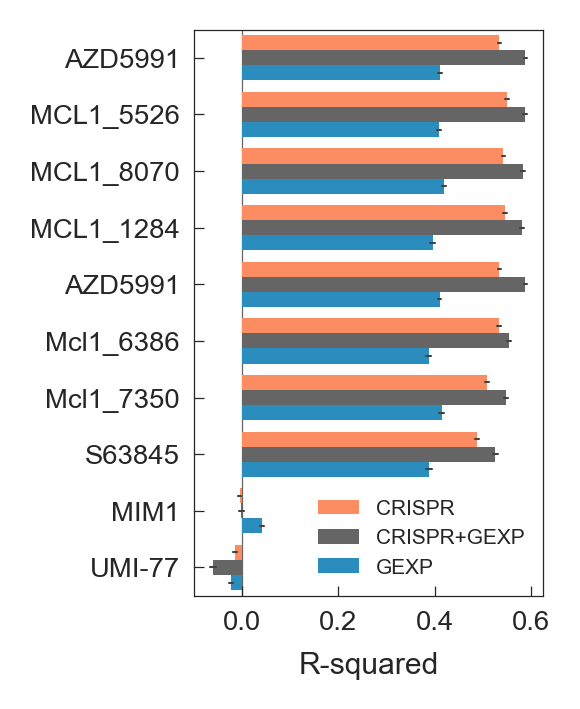

In [10]:
plt.figure(figsize=(1.5, 2.5), dpi=300)
hit.predict_r2_barplot(drug_lms)
plt.savefig(f"{rpath}/hit_rsqaured_barplot.pdf", bbox_inches="tight", transparent=True)

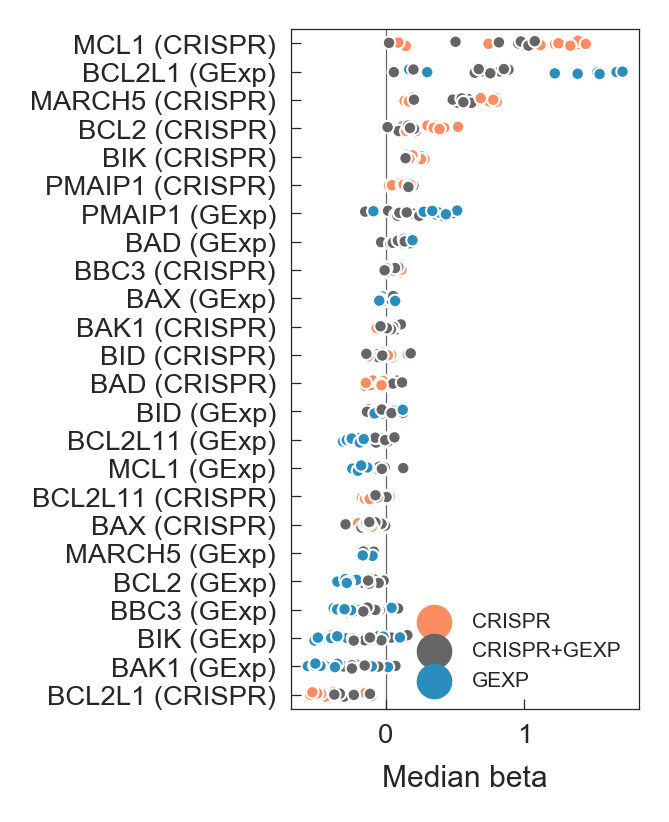

In [11]:
plt.figure(figsize=(1.5, 3), dpi=300)
hit.predict_feature_plot(drug_lms)
plt.savefig(
    f"{rpath}/hit_features_stripplot.pdf", bbox_inches="tight", transparent=True
)

### Gene-essentiality correlation plots

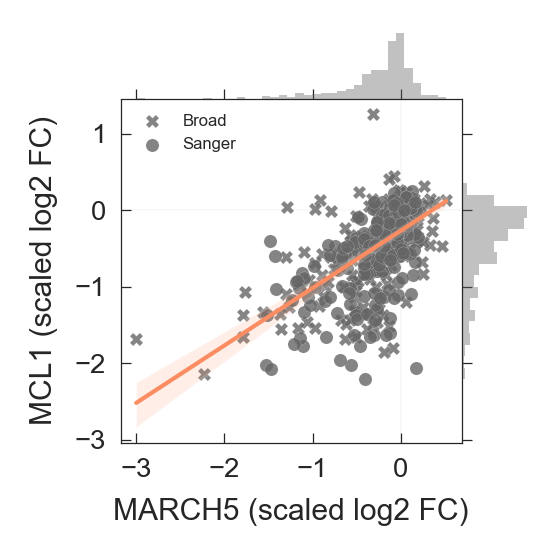

In [12]:
genes = [("MARCH5", "MCL1")]
for gene_x, gene_y in genes:
    plot_df = pd.concat(
        [
            assoc.crispr.loc[gene_x].rename(gene_x),
            assoc.crispr.loc[gene_y].rename(gene_y),
            assoc.crispr_obj.institute.rename("Institute"),
        ],
        axis=1,
        sort=False,
    ).dropna()

    g = DTracePlot().plot_corrplot(gene_x, gene_y, "Institute", plot_df, add_hline=True)

    g.set_axis_labels(f"{gene_x} (scaled log2 FC)", f"{gene_y} (scaled log2 FC)")

    plt.gcf().set_size_inches(1.5, 1.5)
    plt.savefig(
        f"{rpath}/hit_scatter_{gene_x}_{gene_y}.pdf",
        bbox_inches="tight",
        transparent=True,
    )

## Stratification of MCL1i drug-response

### MCL1i inhibitors across all essential cell lines.

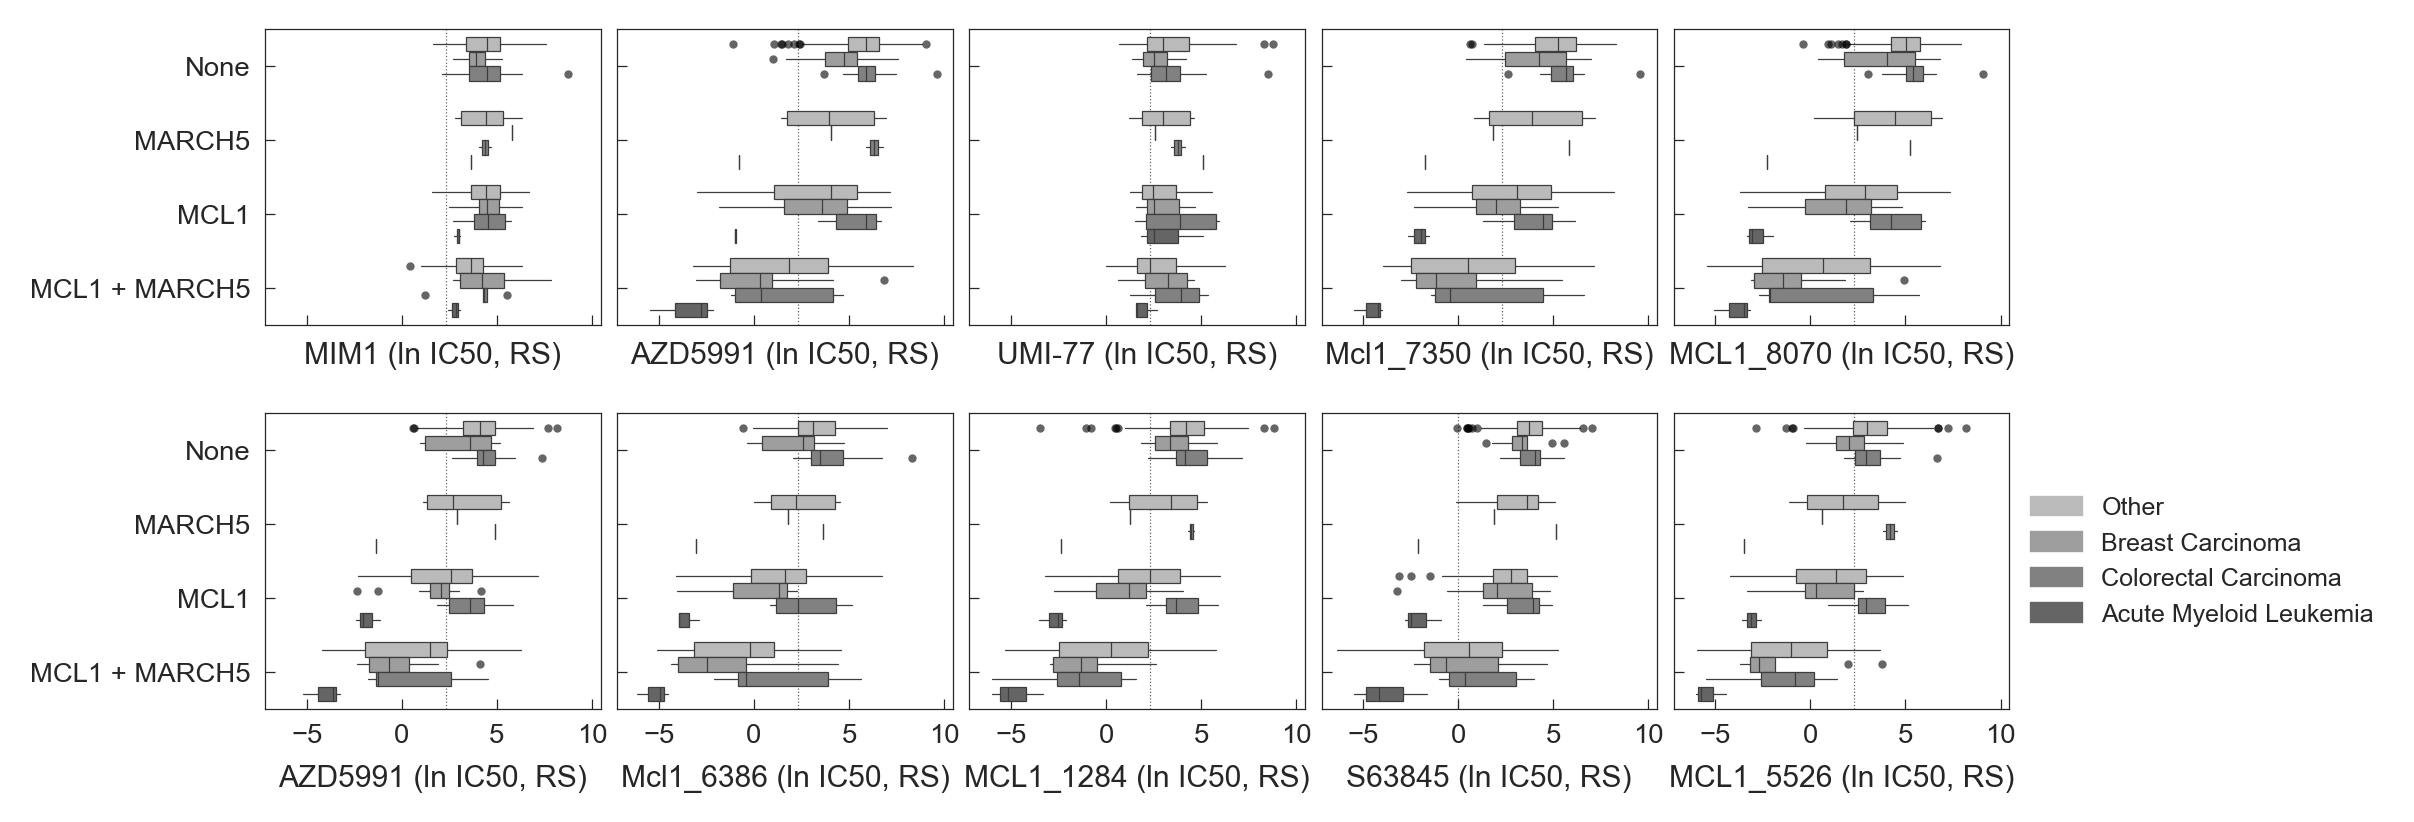

In [14]:
ctypes = ["Breast Carcinoma", "Colorectal Carcinoma", "Acute Myeloid Leukemia"]
genes = ["MCL1", "MARCH5"]
order = ["None", "MARCH5", "MCL1", "MCL1 + MARCH5"]
hue_order = [
    "Other",
    "Breast Carcinoma",
    "Colorectal Carcinoma",
    "Acute Myeloid Leukemia",
]
hit.drugresponse_boxplots(
    assoc, ctypes=ctypes, hue_order=hue_order, order=order, genes=genes
)
plt.savefig(
    f"{rpath}/hit_drugresponse_boxplot.pdf", bbox_inches="tight", transparent=True
)

### Drug-response of highly selective MCL1i (MCL1_1284 and AZD5991) in breast and colorectal carcinomas.

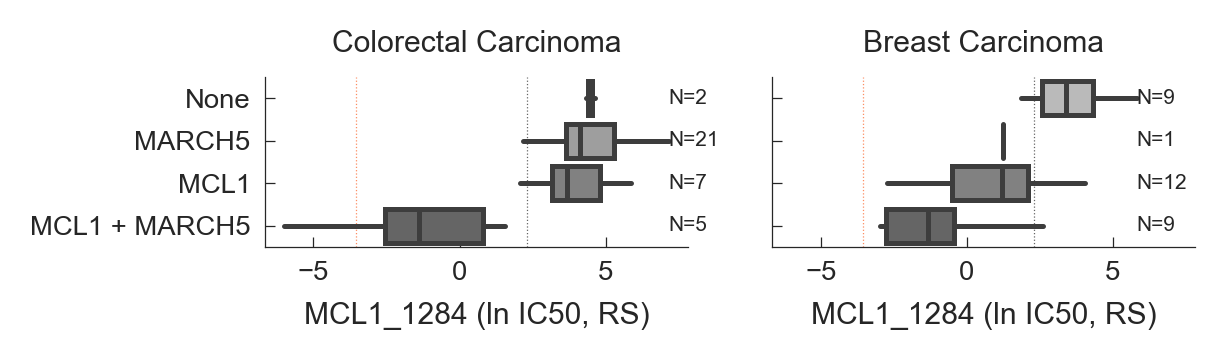

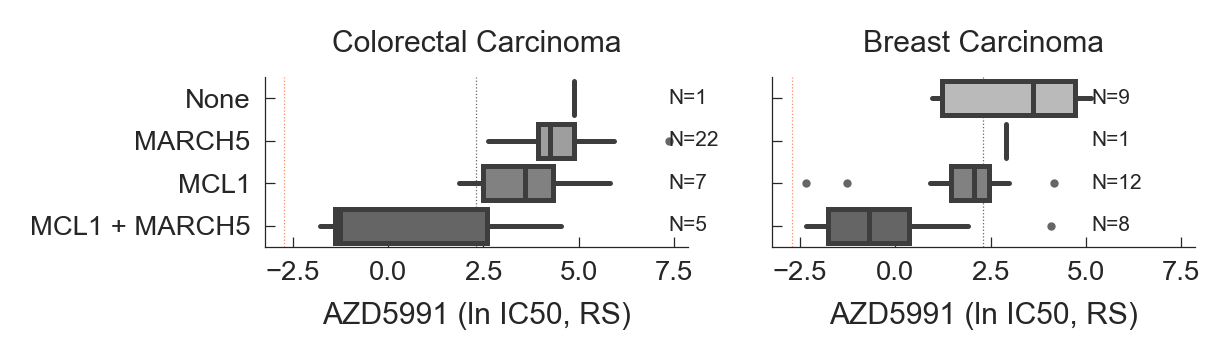

In [15]:
for drug in [(1956, "MCL1_1284", "RS"), (2235, "AZD5991", "RS")]:
    plot_df = pd.concat(
        [
            assoc.drespo.loc[drug].rename("drug"),
            hit.discretise_essentiality(genes, assoc).rename("essentiality"),
            assoc.samplesheet.samplesheet.loc[assoc.samples, "cancer_type"],
        ],
        axis=1,
        sort=False,
    )
    plot_df["ctype"] = plot_df["cancer_type"].apply(
        lambda v: v if v in ctypes else "Other"
    )

    ctypes = ["Colorectal Carcinoma", "Breast Carcinoma"]

    fig, axs = plt.subplots(1, len(ctypes), sharey="all", sharex="all", dpi=300)

    for i, tissue in enumerate(ctypes):
        df = plot_df.query(f"ctype == '{tissue}'")

        g = DTracePlot().plot_multiple(
            "drug", "essentiality", df, n_offset=1, n_fontsize=5, ax=axs[i]
        )

        sns.despine(ax=axs[i])

        dmax = np.log(assoc.drespo_obj.maxconcentration[drug])
        axs[i].axvline(
            dmax, linewidth=0.3, color=DTracePlot.PAL_DTRACE[2], ls=":", zorder=0
        )

        daml = plot_df.query("cancer_type == 'Acute Myeloid Leukemia'")["drug"].mean()
        axs[i].axvline(
            daml, linewidth=0.3, color=DTracePlot.PAL_DTRACE[0], ls=":", zorder=0
        )

        axs[i].set_xlabel(f"{drug[1]} (ln IC50, {drug[2]})")
        axs[i].set_ylabel("")

        axs[i].set_title(tissue)

    plt.gcf().set_size_inches(2 * len(ctypes), 0.75)
    plt.savefig(
        f"{rpath}/hit_drugresponse_boxplot_tissue_{drug[1]}.pdf",
        bbox_inches="tight",
        transparent=True,
    )

### MCL1 copy-number amplification

MCL1 copy-number amplification association with drug-response of MCL1 gene-essentiality and inhibitor.

In [16]:
d, c = ("MCL1_1284", "MCL1")
drug = assoc.lmm_drug_crispr[
    (assoc.lmm_drug_crispr["DRUG_NAME"] == d)
    & (assoc.lmm_drug_crispr["GeneSymbol"] == c)
].iloc[0]
drug = tuple(drug[assoc.drespo_obj.DRUG_COLUMNS])
dmax = np.log(assoc.drespo_obj.maxconcentration[drug])

In [17]:
plot_df = pd.concat(
    [
        assoc.drespo.loc[drug].rename("drug"),
        assoc.crispr.loc[c].rename("crispr"),
        assoc.cn.loc["MCL1"].rename("cn"),
        assoc.crispr_obj.institute.rename("Institute"),
        assoc.samplesheet.samplesheet["ploidy"],
    ],
    axis=1,
    sort=False,
).dropna()
plot_df = plot_df.assign(
    amp=[
        1 if ((p <= 2.7) and (c >= 5)) or ((p > 2.7) and (c >= 9)) else 0
        for p, c in plot_df[["ploidy", "cn"]].values
    ]
)

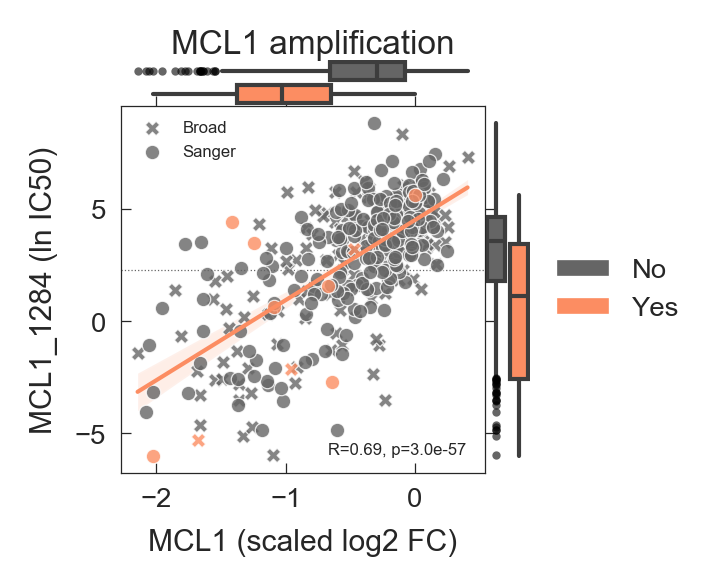

In [18]:
grid = DTracePlot.plot_corrplot_discrete("crispr", "drug", "amp", "Institute", plot_df)
grid.ax_joint.axhline(
    y=dmax, linewidth=0.3, color=DTracePlot.PAL_DTRACE[2], ls=":", zorder=0
)
grid.set_axis_labels(f"{c} (scaled log2 FC)", f"{d} (ln IC50)")
plt.suptitle("MCL1 amplification", y=1.05, fontsize=8)
plt.gcf().set_size_inches(1.5, 1.5)
plt.savefig(
    f"{rpath}/hit_scatter_{d}_{c}_amp.pdf", bbox_inches="tight", transparent=True
)

Copyright (C) 2019 Emanuel Goncalves